# Neural Networks

### Prepare the Data

In [322]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras.utils import to_categorical
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Input, TimeDistributed, Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
import keras
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, classification_report
import h5py
import cv2
from scipy import ndimage
from pylab import *
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot
from PIL import *
%matplotlib inline


# Import various components for model building

# import the backend

# accuracy functions from https://datascience.stackexchange.com/questions/14415/how-does-keras-calculate-accuracy


def get_categorical_accuracy_keras(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

def get_binary_accuracy_keras(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [141]:
# Read the data into data frames.
train_images = pd.read_csv(
    'volcanoesvenus/Volcanoes_train/train_images.csv', header=-1)
train_labels = pd.read_csv('volcanoesvenus/Volcanoes_train/train_labels.csv')

In [142]:
test_images = pd.read_csv(
    'volcanoesvenus/Volcanoes_test/test_images.csv', header=-1)
test_labels = pd.read_csv('volcanoesvenus/Volcanoes_test/test_labels.csv')

In [145]:
print(test_images.shape)
print(test_labels.shape)
print(train_images.shape)
print(train_labels.shape)

(2734, 12100)
(2734, 4)
(7000, 12100)
(7000, 4)


In [148]:
X_train = train_images / 255
X_test = test_images / 255
y_train = train_labels['Volcano?']
y_test = test_labels['Volcano?']

In [149]:
# Ensure type is float32 and convert labels to binary.
num_classes = 2

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 12100)
(2734, 12100)
(7000, 2)
(2734, 2)


In [150]:
# Convert independent variable data frames to arrays.
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train_mlp = X_train
X_test_mlp = X_test
y_train_mlp = y_train
y_test_mlp = y_test

print(X_train_mlp.shape)
print(y_train_mlp.shape)

(7000, 12100)
(7000, 2)


In [151]:
# Reshape for input into our neural network.
img_rows, img_cols = 110, 110

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print(X_train.shape)
print(X_test.shape)

(7000, 110, 110, 1)
(2734, 110, 110, 1)


## Train the Models

### Multi Layer Perceptron

In [134]:
mlp_model = Sequential()

mlp_model.add(Dense(64, activation='relu', input_shape=(img_rows*img_cols,)))
mlp_model.add(Dropout(0.1))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.1))

mlp_model.add(Dense(2, activation='softmax'))

mlp_model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=[get_categorical_accuracy_keras])

mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 64)                774464    
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 130       
Total params: 778,754
Trainable params: 778,754
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = mlp_model.fit(X_train_mlp, y_train_mlp,
                        batch_size=128,
                        epochs=10,
                        verbose=1,
                        validation_data=(X_test_mlp, y_test_mlp))

Train on 7000 samples, validate on 2734 samples
Epoch 1/10
7000/7000 [==============================] - 4s 512us/step - loss: 2.3809 - get_categorical_accuracy_keras: 0.8519 - val_loss: 2.5675 - val_get_categorical_accuracy_keras: 0.8413
Epoch 2/10
7000/7000 [==============================] - 3s 398us/step - loss: 2.3079 - get_categorical_accuracy_keras: 0.8571 - val_loss: 2.5622 - val_get_categorical_accuracy_keras: 0.8413
Epoch 3/10
7000/7000 [==============================] - 3s 412us/step - loss: 2.3044 - get_categorical_accuracy_keras: 0.8571 - val_loss: 2.5594 - val_get_categorical_accuracy_keras: 0.8413
Epoch 4/10
7000/7000 [==============================] - 3s 397us/step - loss: 2.3029 - get_categorical_accuracy_keras: 0.8571 - val_loss: 2.5587 - val_get_categorical_accuracy_keras: 0.8413
Epoch 5/10
7000/7000 [==============================] - 3s 400us/step - loss: 2.3026 - get_categorical_accuracy_keras: 0.8571 - val_loss: 2.5586 - val_get_categorical_accuracy_keras: 0.8413
Ep

In [661]:
# Define a function to provide classification statistics for each model.
def get_nn_stats(model, X_train, X_test, y_train, y_test):

    model_score = model.evaluate(X_train, y_train, verbose=0)
    print('Train loss:', model_score[0])
    print('Train accuracy:', model_score[1], '\n')

    model_test_score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', model_test_score[0])
    print('Test accuracy:', model_test_score[1], '\n')

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Confusion Matrix
    print('Confusion matrix on training data')
    print(confusion_matrix(y_train.argmax(axis=1), y_pred_train.argmax(axis=1)))
    print('Confusion matrix on testing data')
    print(confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1)), '\n')

    # Recall/Sensitivity
    print('Recall score on training data')
    print(recall_score(y_train.argmax(axis=1), y_pred_train.argmax(axis=1)))
    print('Recall score on testing data')
    print(recall_score(y_test.argmax(axis=1), y_pred_test.argmax(axis=1)), '\n')

    # Specificity
    print('Specificity on training data')
    print(confusion_matrix(y_train.argmax(axis=1), y_pred_train.argmax(axis=1))[0][0] /
          (confusion_matrix(y_train.argmax(axis=1), y_pred_train.argmax(axis=1))[0][0] +
           confusion_matrix(y_train.argmax(axis=1), y_pred_train.argmax(axis=1))[0][1]))
    print('Specificity on testing data')
    print(confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))[0][0] /
          (confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))[0][0] +
           confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))[0][1]), '\n')

    # Precision
    print('Precision score on training data')
    print(precision_score(y_train.argmax(axis=1), y_pred_train.argmax(axis=1)))
    print('Precision score on testing data')
    print(precision_score(y_test.argmax(axis=1), y_pred_test.argmax(axis=1)), '\n')

    # F1 Score
    print('F1 score on training data')
    print(f1_score(y_train.argmax(axis=1), y_pred_train.argmax(axis=1)))
    print('F1 score on testing data')
    print(f1_score(y_test.argmax(axis=1), y_pred_test.argmax(axis=1)))

    return None

In [642]:
get_nn_stats(mlp_model, X_train_mlp, X_test_mlp, y_train, y_test)

Train loss: 2.302585060732705
Train accuracy: 0.8571428570747376 

Test loss: 2.558615000996175
Test accuracy: 0.8412582295692655 

Confusion matrix on training data
[[6000    0]
 [1000    0]]
Confusion matrix on testing data
[[2300    0]
 [ 434    0]] 

Recall score on training data
0.0
Recall score on testing data
0.0 

Specificity on training data
1.0
Specificity on testing data
1.0 

Precision score on training data
0.0
Precision score on testing data
0.0 

F1 score on training data
0.0
F1 score on testing data
0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### CNN I

In [323]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, 1)), )
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(64))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.1))

cnn_model.add(Dense(64))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(2))
cnn_model.add(Activation('softmax'))

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=[get_categorical_accuracy_keras])

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 108, 108, 32)      320       
_________________________________________________________________
activation_37 (Activation)   (None, 108, 108, 32)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 52, 52, 32)        9248      
_________________________________________________________________
activation_38 (Activation)   (None, 52, 52, 32)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 64)        18496     
__________

In [324]:
history = cnn_model.fit(X_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_data=(X_test, y_test))

Train on 7000 samples, validate on 2734 samples
Epoch 1/10
7000/7000 [==============================] - 129s 18ms/step - loss: 0.4284 - get_categorical_accuracy_keras: 0.8524 - val_loss: 0.4342 - val_get_categorical_accuracy_keras: 0.8413
Epoch 2/10
7000/7000 [==============================] - 115s 16ms/step - loss: 0.4142 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4280 - val_get_categorical_accuracy_keras: 0.8413
Epoch 3/10
7000/7000 [==============================] - 115s 16ms/step - loss: 0.3930 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.3657 - val_get_categorical_accuracy_keras: 0.8413
Epoch 4/10
7000/7000 [==============================] - 115s 16ms/step - loss: 0.2390 - get_categorical_accuracy_keras: 0.9069 - val_loss: 0.1813 - val_get_categorical_accuracy_keras: 0.9382
Epoch 5/10
7000/7000 [==============================] - 108s 15ms/step - loss: 0.1625 - get_categorical_accuracy_keras: 0.9459 - val_loss: 0.1534 - val_get_categorical_accuracy_keras: 0.94

In [616]:
get_nn_stats(cnn_model, X_train, X_test, y_train, y_test)

Train loss: 0.05376333166978189
Train accuracy: 0.982 

Test loss: 0.11292122184668872
Test accuracy: 0.9659839063643014 

Confusion matrix on training data
[[5975   25]
 [ 101  899]]
Confusion matrix on testing data
[[2278   22]
 [  71  363]] 

Recall score on training data
0.899
Recall score on testing data
0.836405529953917 

Specificity on training data
0.9958333333333333
Specificity on testing data
0.9904347826086957 

Precision score on training data
0.9729437229437229
Precision score on testing data
0.9428571428571428 

F1 score on training data
0.9345114345114345
F1 score on testing data
0.8864468864468864


### CNN II with ImageDataGenerator

In [652]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    rotation_range=180,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(X_train)

/usr/local/lib/python3.7/site-packages/keras/preprocessing/image.py:504: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/site-packages/keras/preprocessing/image.py:511: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [653]:
cnn_model2 = Sequential()

cnn_model2.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, 1)), )
cnn_model2.add(Activation('relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model2.add(Conv2D(32, (3, 3)))
cnn_model2.add(Activation('relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model2.add(Conv2D(64, (3, 3)))
cnn_model2.add(Activation('relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model2.add(Flatten())

cnn_model2.add(Dense(64))
cnn_model2.add(Activation('relu'))
cnn_model2.add(Dropout(0.1))

cnn_model2.add(Dense(64))
cnn_model2.add(Activation('relu'))
cnn_model2.add(Dropout(0.2))

cnn_model2.add(Dense(2))
cnn_model2.add(Activation('softmax'))

cnn_model2.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=[get_categorical_accuracy_keras])

In [654]:
history2 = cnn_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                    epochs=10,
                                    validation_data=[X_test, y_test])

Epoch 1/10
110/110 [==============================] - 123s 1s/step - loss: 2.2989 - get_categorical_accuracy_keras: 0.8541 - val_loss: 1.7125 - val_get_categorical_accuracy_keras: 0.8413
Epoch 2/10
110/110 [==============================] - 124s 1s/step - loss: 2.2934 - get_categorical_accuracy_keras: 0.8577 - val_loss: 1.7126 - val_get_categorical_accuracy_keras: 0.8413
Epoch 3/10
110/110 [==============================] - 119s 1s/step - loss: 2.2972 - get_categorical_accuracy_keras: 0.8575 - val_loss: 1.7126 - val_get_categorical_accuracy_keras: 0.8413
Epoch 4/10
110/110 [==============================] - 116s 1s/step - loss: 2.3085 - get_categorical_accuracy_keras: 0.8568 - val_loss: 1.7126 - val_get_categorical_accuracy_keras: 0.8413
Epoch 5/10
110/110 [==============================] - 130s 1s/step - loss: 2.3085 - get_categorical_accuracy_keras: 0.8568 - val_loss: 1.7126 - val_get_categorical_accuracy_keras: 0.8413
Epoch 6/10
110/110 [==============================] - 132s 1s/ste

In [655]:
get_nn_stats(cnn_model2, X_train, X_test, y_train, y_test)

Train loss: 1.528217015115145
Train accuracy: 0.8571428570747376 

Test loss: 1.7125942921586166
Test accuracy: 0.8412582295692655 

Confusion matrix on training data
[[6000    0]
 [1000    0]]
Confusion matrix on testing data
[[2300    0]
 [ 434    0]] 

Recall score on training data
0.0
Recall score on testing data
0.0 

Specificity on training data
1.0
Specificity on testing data
1.0 

Precision score on training data
0.0
Precision score on testing data
0.0 

F1 score on training data
0.0
F1 score on testing data
0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### CNN III

In [643]:
# Add another Conv2D layer as well as one dropout before flattening.
cnn_model4 = Sequential()

cnn_model4.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, 1)), )
cnn_model4.add(Activation('relu'))
cnn_model4.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model4.add(Conv2D(32, (3, 3)))
cnn_model4.add(Activation('relu'))
cnn_model4.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model4.add(Conv2D(64, (3, 3)))
cnn_model4.add(Activation('relu'))
cnn_model4.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(Dropout(0.1))

cnn_model4.add(Conv2D(64, (3, 3)))
cnn_model4.add(Activation('relu'))
cnn_model4.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model4.add(Flatten())

cnn_model4.add(Dense(64))
cnn_model4.add(Activation('relu'))
cnn_model4.add(Dropout(0.1))

cnn_model4.add(Dense(64))
cnn_model4.add(Activation('relu'))
cnn_model4.add(Dropout(0.2))

cnn_model4.add(Dense(2))
cnn_model4.add(Activation('softmax'))

cnn_model4.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=[get_categorical_accuracy_keras])

In [644]:
history = cnn_model4.fit(X_train, y_train,
                         batch_size=64,
                         epochs=15,
                         validation_data=(X_test, y_test))

Train on 7000 samples, validate on 2734 samples
Epoch 1/15
7000/7000 [==============================] - 130s 19ms/step - loss: 0.4453 - get_categorical_accuracy_keras: 0.8497 - val_loss: 0.4449 - val_get_categorical_accuracy_keras: 0.8413
Epoch 2/15
7000/7000 [==============================] - 128s 18ms/step - loss: 0.4143 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4314 - val_get_categorical_accuracy_keras: 0.8413
Epoch 3/15
7000/7000 [==============================] - 123s 18ms/step - loss: 0.4124 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4376 - val_get_categorical_accuracy_keras: 0.8413
Epoch 4/15
7000/7000 [==============================] - 118s 17ms/step - loss: 0.4060 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4234 - val_get_categorical_accuracy_keras: 0.8413
Epoch 5/15
7000/7000 [==============================] - 118s 17ms/step - loss: 0.3429 - get_categorical_accuracy_keras: 0.8713 - val_loss: 0.2375 - val_get_categorical_accuracy_keras: 0.91

In [645]:
get_nn_stats(cnn_model4, X_train, X_test, y_train, y_test)

Train loss: 0.056210491585678285
Train accuracy: 0.9814285714285714 

Test loss: 0.10055032343264389
Test accuracy: 0.9703730797366495 

Confusion matrix on training data
[[5986   14]
 [ 116  884]]
Confusion matrix on testing data
[[2289   11]
 [  70  364]] 

Recall score on training data
0.884
Recall score on testing data
0.8387096774193549 

Specificity on training data
0.9976666666666667
Specificity on testing data
0.9952173913043478 

Precision score on training data
0.9844097995545658
Precision score on testing data
0.9706666666666667 

F1 score on training data
0.9315068493150684
F1 score on testing data
0.8998763906056861


### CNN IV

In [638]:
# Add yet another Conv2D layer, reduce number of perceptrons in each.
cnn_model5 = Sequential()

cnn_model5.add(Conv2D(16, (3, 3), input_shape=(img_rows, img_cols, 1)), )
cnn_model5.add(Activation('relu'))
cnn_model5.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model5.add(Conv2D(16, (3, 3)))
cnn_model5.add(Activation('relu'))
cnn_model5.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model5.add(Conv2D(16, (3, 3)))
cnn_model5.add(Activation('relu'))
cnn_model5.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model5.add(Conv2D(32, (3, 3)))
cnn_model5.add(Activation('relu'))
cnn_model5.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model5.add(Dropout(0.1))

cnn_model5.add(Conv2D(32, (3, 3)))
cnn_model5.add(Activation('relu'))
cnn_model5.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model5.add(Flatten())

cnn_model5.add(Dense(64))
cnn_model5.add(Activation('relu'))
cnn_model5.add(Dropout(0.1))

cnn_model5.add(Dense(64))
cnn_model5.add(Activation('relu'))
cnn_model5.add(Dropout(0.2))

cnn_model5.add(Dense(2))
cnn_model5.add(Activation('softmax'))

cnn_model5.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=[get_categorical_accuracy_keras])

In [639]:
history = cnn_model5.fit(X_train, y_train,
                         batch_size=64,
                         epochs=10,
                         validation_data=(X_test, y_test))

Train on 7000 samples, validate on 2734 samples
Epoch 1/10
7000/7000 [==============================] - 47s 7ms/step - loss: 0.4480 - get_categorical_accuracy_keras: 0.8520 - val_loss: 0.4377 - val_get_categorical_accuracy_keras: 0.8413
Epoch 2/10
7000/7000 [==============================] - 51s 7ms/step - loss: 0.4148 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4341 - val_get_categorical_accuracy_keras: 0.8413
Epoch 3/10
7000/7000 [==============================] - 49s 7ms/step - loss: 0.4118 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4430 - val_get_categorical_accuracy_keras: 0.8413
Epoch 4/10
7000/7000 [==============================] - 51s 7ms/step - loss: 0.4117 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4330 - val_get_categorical_accuracy_keras: 0.8413
Epoch 5/10
7000/7000 [==============================] - 49s 7ms/step - loss: 0.4089 - get_categorical_accuracy_keras: 0.8571 - val_loss: 0.4311 - val_get_categorical_accuracy_keras: 0.8413
Epoch 6

In [640]:
get_nn_stats(cnn_model5, X_train, X_test, y_train, y_test)

Train loss: 0.17314286294153758
Train accuracy: 0.9407142856461661 

Test loss: 0.19755702647268117
Test accuracy: 0.9294074614639254 

Confusion matrix on training data
[[5919   81]
 [ 334  666]]
Confusion matrix on testing data
[[2265   35]
 [ 158  276]] 

Recall score on training data
0.666
Recall score on testing data
0.6359447004608295 

Specificity on training data
0.9865
Specificity on testing data
0.9847826086956522 

Precision score on training data
0.891566265060241
Precision score on testing data
0.887459807073955 

F1 score on training data
0.7624499141385233
F1 score on testing data
0.7409395973154362


## Analyze the Best Model

In [610]:
# Get sample of results
def get_best_images(model, X_train, X_test, y_train, y_test, test_images):
    y_pred_train_best = model.predict(X_train)
    y_pred_test_best = model.predict(X_test)

    y_pred_test_best = pd.DataFrame(y_pred_test_best)
    y_pred_test_best.columns = ['0', '1']

    y_test_best = y_pred_test_best['1'].sort_values(ascending=False).head(10)

    test = test_images.join(
        y_test_best, lsuffix='test_images', rsuffix='best_preds')
    test = test.dropna()

    plt.subplots(figsize=(16, 7))
    sns.despine
    for i in range(10):
        plt.subplot(2, 5, i+1, xlabel=(str(test.iloc[i, -1:])))
        plt.imshow(test.iloc[i, :-1].values.reshape((110, 110)), cmap='gray')

    return plt.show()

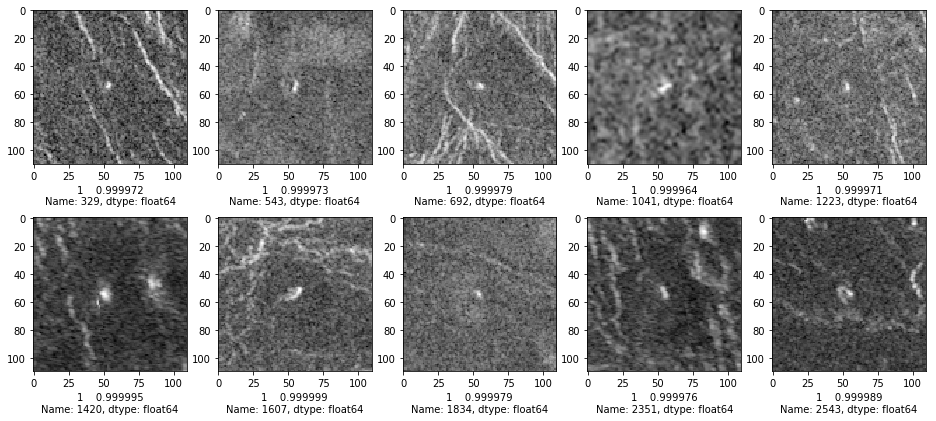

In [663]:
get_best_images(cnn_model4, X_train, X_test, y_train, y_test, test_images)

In [ ]:
# Get type I error images
def get_type_i(model, X_train, X_test, y_train, y_test, test_images, test_labels):
    y_test_pred_classes = model.predict_classes(X_test)
    y_pred_test_best = model.predict(X_test)

    y_pred_test_best = pd.DataFrame(y_pred_test_best)
    y_pred_test_best.columns = ['0', '1']

    y_test_labels = pd.DataFrame(test_labels['Volcano?'])
    y_test_labels['pred'] = y_test_pred_classes

    type1_error_test = y_test_labels[(
        y_test_labels['Volcano?'] == 0) & (y_test_labels.pred == 1)]

    type1_images = test_images.join(
        type1_error_test, lsuffix='test_images', rsuffix='type1_error')
    type1_images = type1_images.dropna()

    type1_images = type1_images.join(
        y_pred_test_best, lsuffix='images', rsuffix='probability')

    plt.subplots(figsize=(16, 8))
    sns.despine
    for i in range(10):
        plt.subplot(2, 5, i+1, xlabel=('Volcano=' + str(type1_images['Volcano?'].iloc[i]) + '\n' +
                                       'Prediction=' + str(type1_images.pred.iloc[i]) + '\n' +
                                       'Probability=' + str(type1_images.iloc[i, -1])))
        plt.imshow(
            type1_images.iloc[i, :-4].values.reshape((110, 110)), cmap='gray')

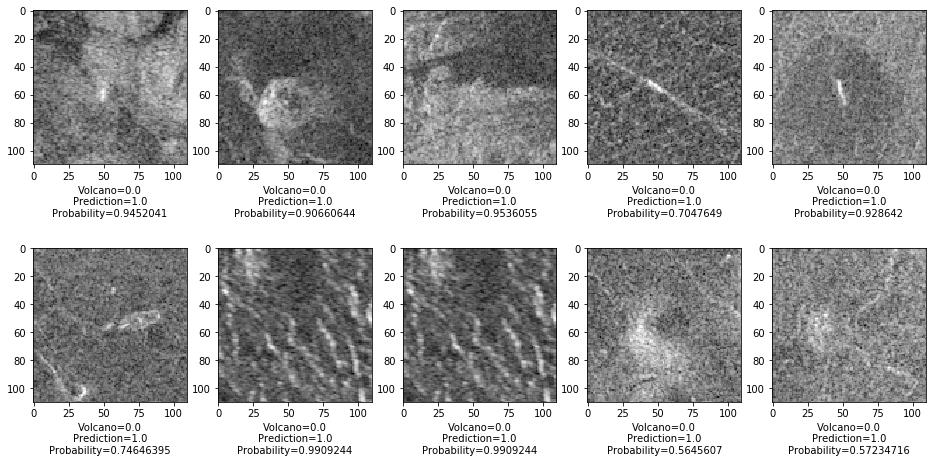

In [649]:
get_type_i(cnn_model4, X_train, X_test, y_train,
           y_test, test_images, test_labels)

In [612]:
# Get type II error images
def get_type_ii(model, X_train, X_test, y_train, y_test, test_images, test_labels):
    y_test_pred_classes = pd.DataFrame(model.predict_classes(X_test))
    y_pred_test_best = model.predict(X_test)
    y_pred_test_best = pd.DataFrame(y_pred_test_best, columns=['0', '1'])
    y_test_labels2 = pd.DataFrame(test_labels['Volcano?'])
    y_test_labels2['pred'] = y_test_pred_classes
    type2_error_test = y_test_labels2[(
        y_test_labels2['Volcano?'] == 1) & (y_test_labels2.pred == 0)]

    type2_images = test_images.join(
        type2_error_test, lsuffix='test_images', rsuffix='type2_error')
    type2_images = type2_images.dropna()
    type2_images = type2_images.join(
        y_pred_test_best, lsuffix='images', rsuffix='probability')

    plt.subplots(figsize=(16, 8))
    sns.despine
    for i in range(10):
        plt.subplot(2, 5, i+1, xlabel=('Volcano=' + str(type2_images['Volcano?'].iloc[i]) + '\n' +
                                       'Prediction=' + str(type2_images.pred.iloc[i]) + '\n' +
                                       'Probability=' + str(type2_images.iloc[i, -2])))
        plt.imshow(
            type2_images.iloc[i, :-4].values.reshape((110, 110)), cmap='gray')

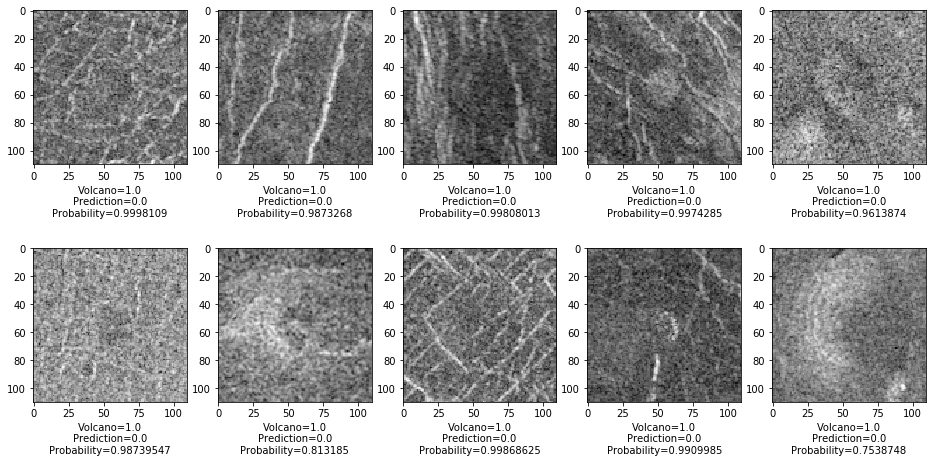

In [650]:
get_type_ii(cnn_model4, X_train, X_test, y_train,
            y_test, test_images, test_labels)